In [22]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost
from itertools import combinations
from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from scipy.special import comb
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 

In [3]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

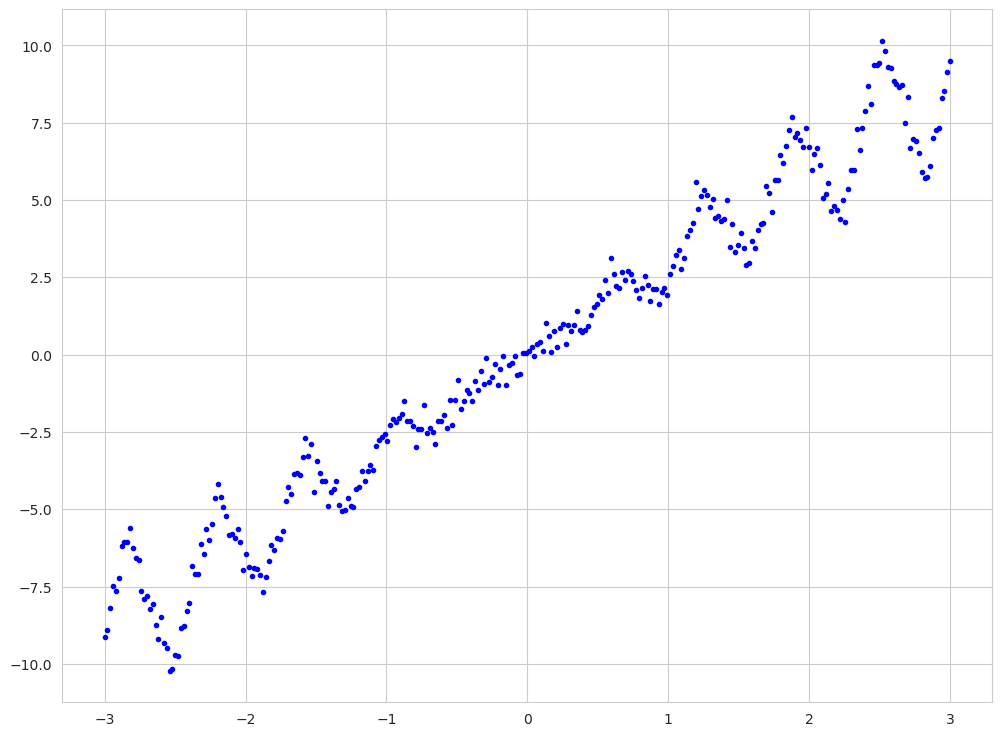

In [5]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [6]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

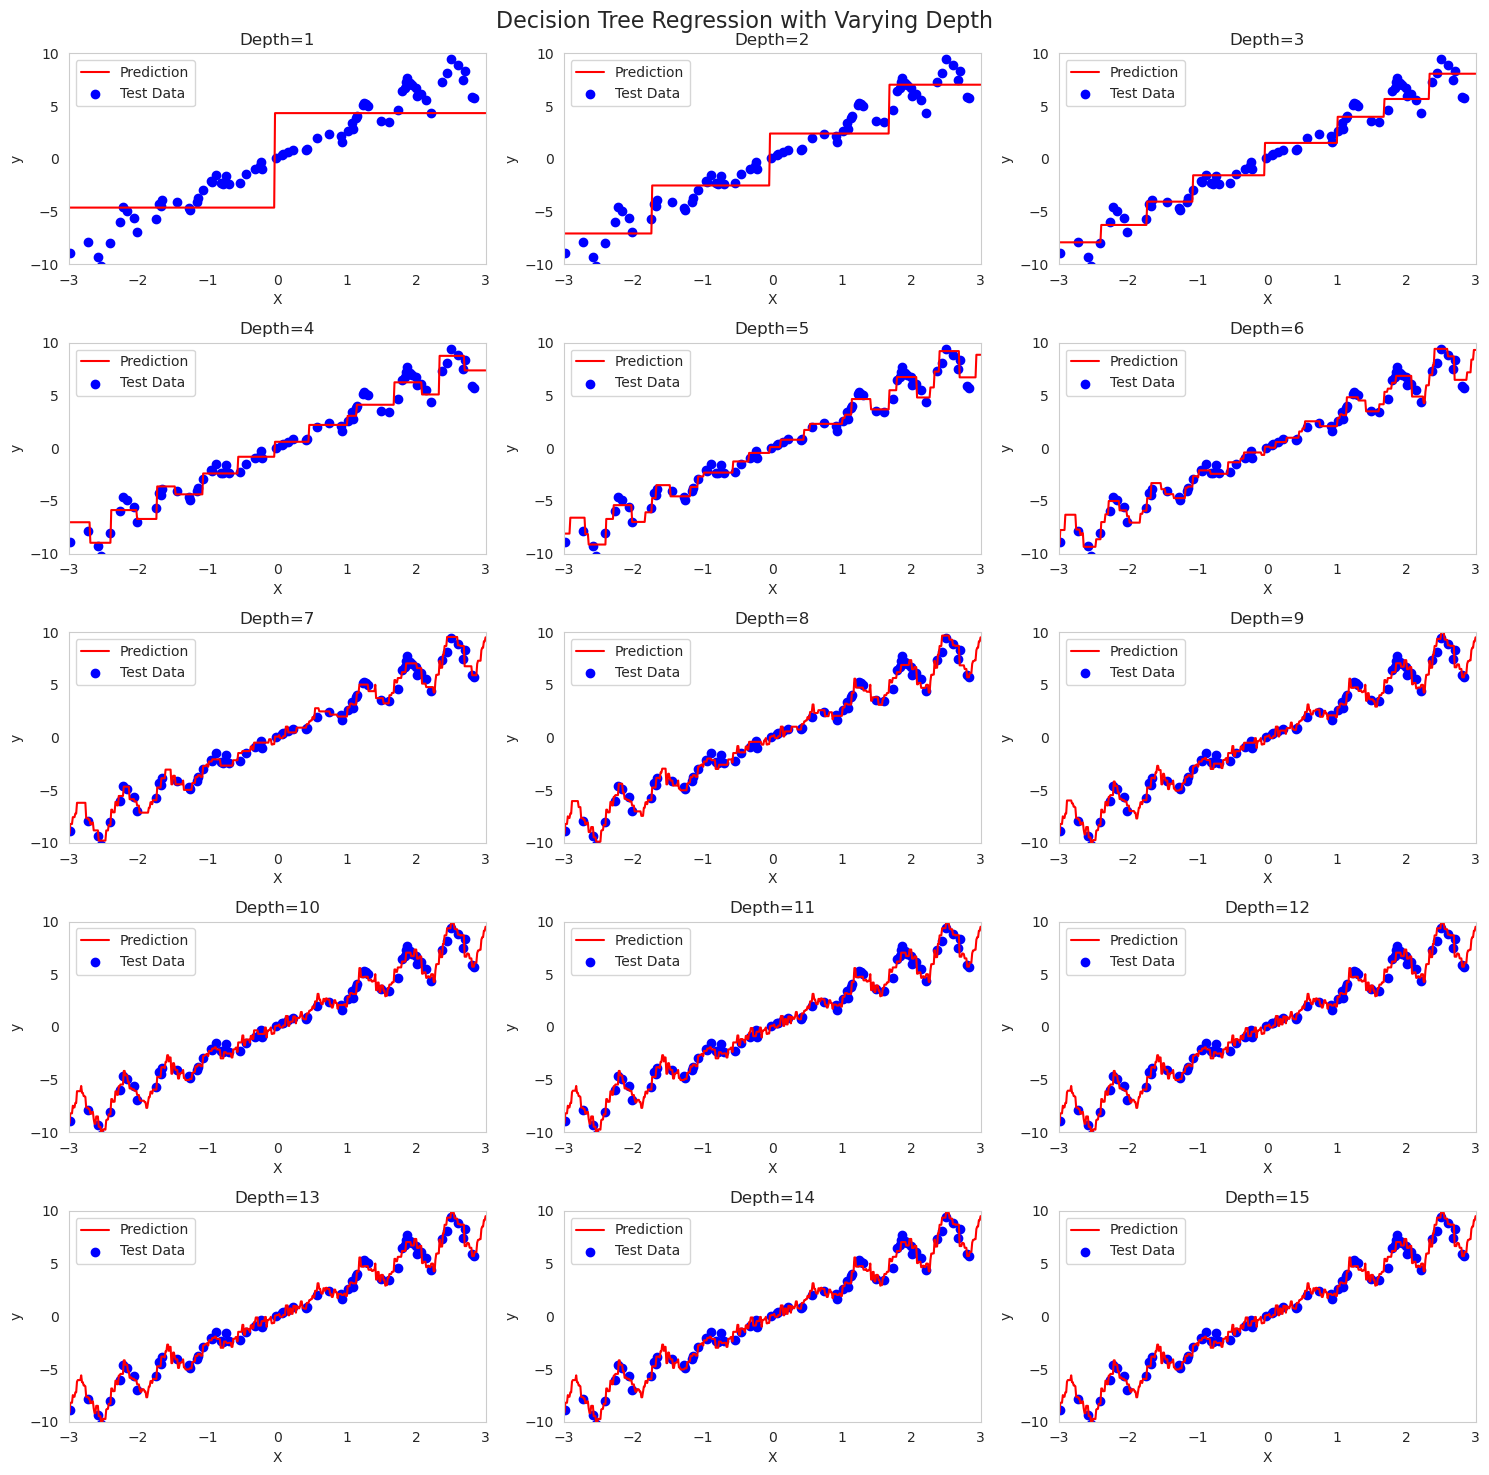

In [8]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
fig.suptitle("Decision Tree Regression with Varying Depth", fontsize=16)

for i, ax in enumerate(axes.flatten(), start=1):
    dtree = DecisionTreeRegressor(max_depth=i)
    dtree.fit(X_train, y_train)
    ax.set_title(f"Depth={i}")
    x_values = np.linspace(-3, 3, 500).reshape(-1, 1)
    y_values = dtree.predict(x_values)
    ax.plot(x_values, y_values, color='r', label='Prediction')
    ax.scatter(X_test, y_test, color='b', label='Test Data')
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-10, 10)
    ax.legend()
    ax.grid(False) #без линейки совсем прелесть

plt.tight_layout()
plt.show()

Depth = 6 кажется наиболее пододящей, поскольку y_pred практически совпадает с train данными, линии более плавные, далее `variance` начинает увеличиваться

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [8]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [9]:
probability = np.arange(0,1.05,0.02)
probs = []

for p in probability:
    probs += [sum(map(lambda i: comb(101, i) * (p**i) * (1 - p) ** (101 - i), range(51, 102)))]

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [10]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

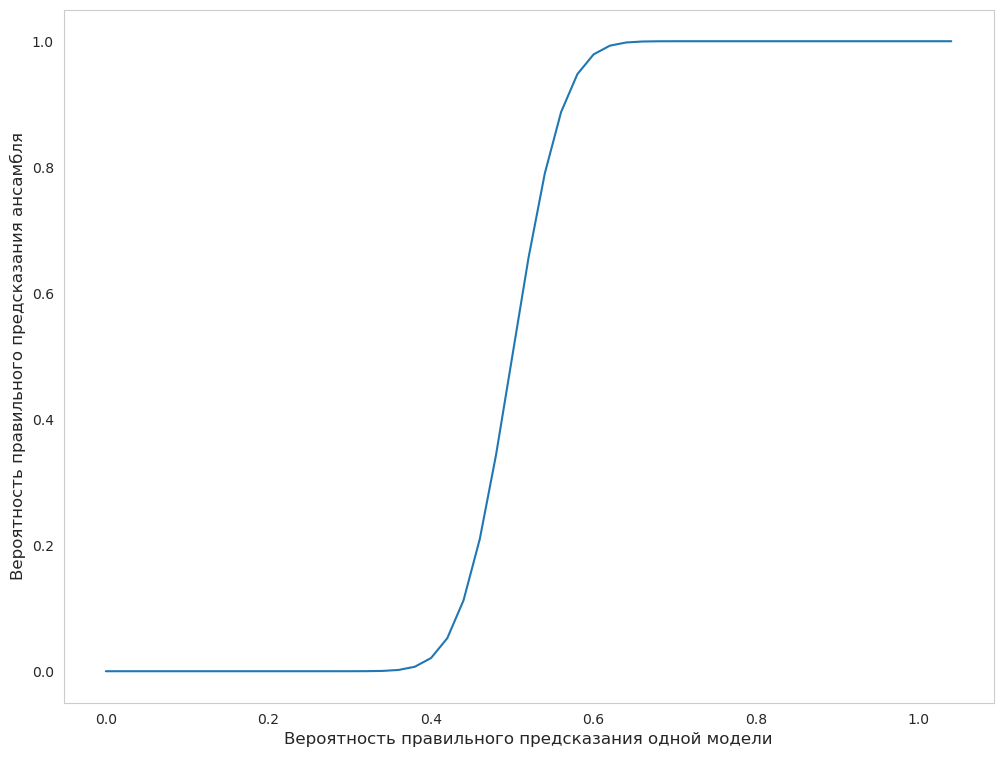

In [10]:
plt.plot(probability, probs)
plt.grid(False)
plt.xlabel("Вероятность правильного предсказания одной модели", fontsize=12)
plt.ylabel("Вероятность правильного предсказания ансамбля", fontsize=12)
plt.show()

Опишите ваши наблюдения:

* для $101$ модели уверенность суммарного предсказания быстро растёт, при $p=0.6$ вероятность правильного предсказания ансамбля моделей $>0.9$;

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [11]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        for i in range(self.n_estimators - 1):
            np.random.seed(self.random_state + i)
            self.feat_ids_by_tree += [np.random.choice(X.shape[1], size = self.max_features)]
            poses = np.random.choice(X.shape[0], size=X.shape[0], 
                                     replace=True)
            X_boot = X[poses][:, self.feat_ids_by_tree[i]]
            y_boot = y[poses]
            clf = DecisionTreeClassifier(max_depth=self.max_depth, 
                                         max_features=self.max_features, 
                                         random_state=self.random_state + i)
            clf.fit(X_boot, y_boot)
            self.trees += [clf]
        return self
        


    def predict_proba(self, X):
        preds = []
        for i in range(len(self.trees)):
            preds += [self.trees[i].predict_proba(X[:, self.feat_ids_by_tree[i]])]
        preds = np.array(preds)
        return np.mean(preds, axis=0)
 
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [12]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

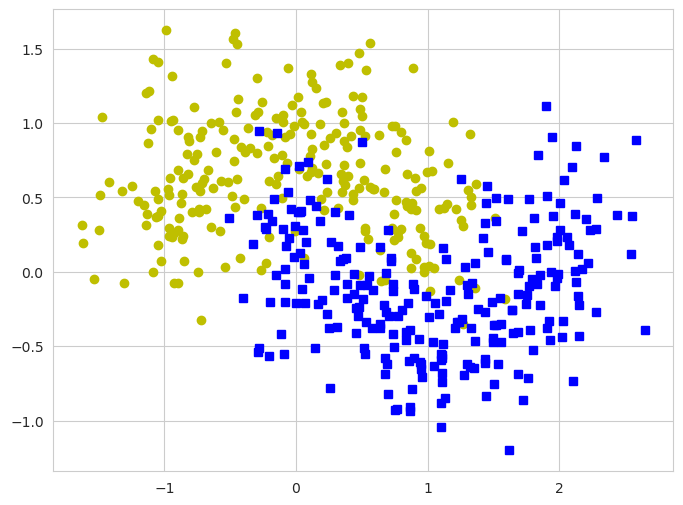

In [13]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [15]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

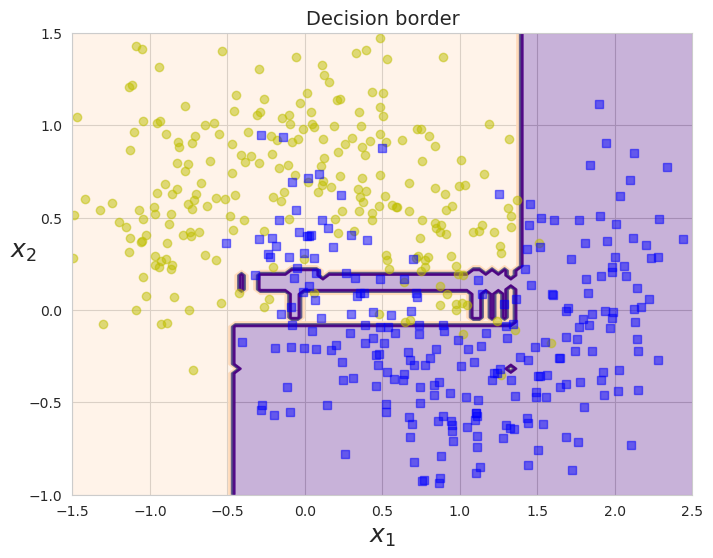

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

plt.figure(figsize=(8, 6))
classif = RandomForestClassifierCustom(max_depth = 4, max_features = 2)
classif.fit(X_train, y_train)
plot_decision_boundary(classif, X, y)
plt.title("Decision border", fontsize=14)
plt.show()

Видим, что модель недообученная

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [17]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [15]:
params = {
    'max_depth': range(1, 20), 
    'max_features' : range(1, 3), 
    'n_estimators' : range(5, 51)
}
best_tree1 = GridSearchCV(classif, params, scoring='accuracy')
best_tree1.fit(X, y)
best_tree1.best_params_

{'max_depth': 6, 'max_features': 2, 'n_estimators': 17}

In [16]:
params = {
    'max_depth': range(1, 20), 
    'max_features' : range(1, 3), 
    'n_estimators' : range(5, 51)
}
best_tree2 = GridSearchCV(classif, params, scoring='f1')
best_tree2.fit(X, y)
best_tree1.best_params_ #совпадают

{'max_depth': 6, 'max_features': 2, 'n_estimators': 17}

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [17]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [18]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [19]:
n_features = list(range(1, X.shape[1] + 1))
correlations = []

for n in n_features:
    classifier = RandomForestClassifier(max_features=n, random_state=SEED)
    classifier.fit(X_train, y_train)
    correlations.append(base_model_pair_correlation(classifier, X))

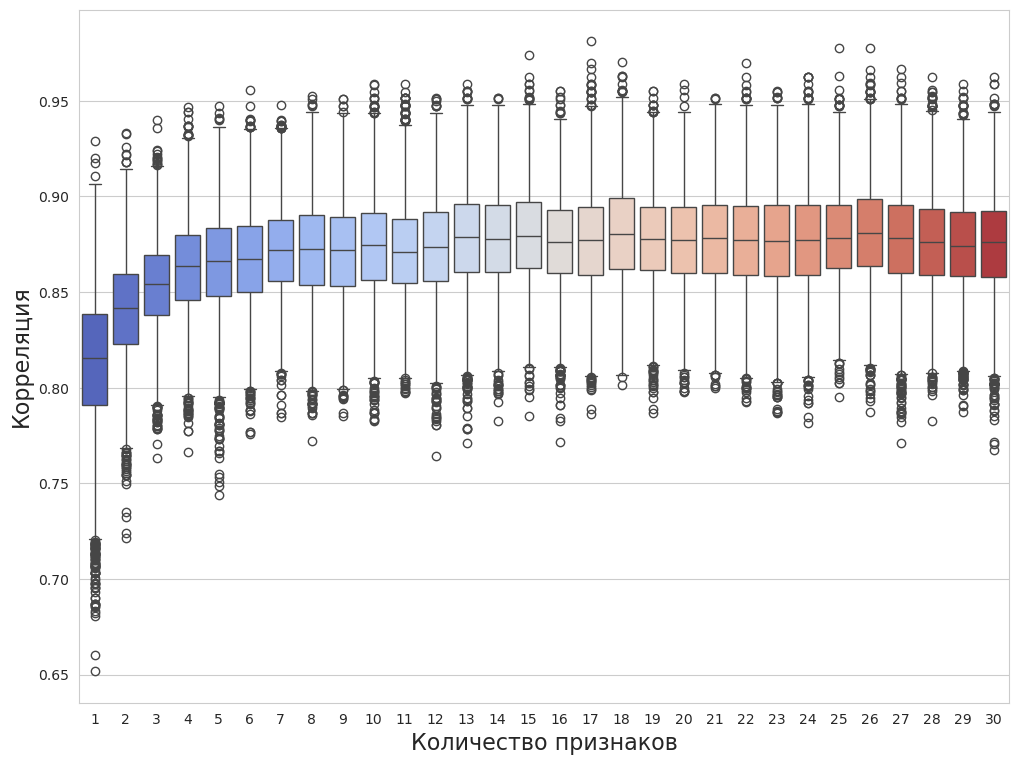

In [20]:
sns.boxplot(x=np.repeat(n_features, len(correlations[0])), y=np.concatenate(correlations), palette="coolwarm")
plt.xlabel("Количество признаков", fontsize=16)
plt.ylabel("Корреляция", fontsize=16)
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [21]:
n_depth = list(range(1, 20))
correlations_d = []
for i in n_depth:
    classf = RandomForestClassifier(max_depth = i, max_features=7, random_state = SEED)
    classf.fit(X_train, y_train)
    correlations_d += [base_model_pair_correlation(classf, X)]

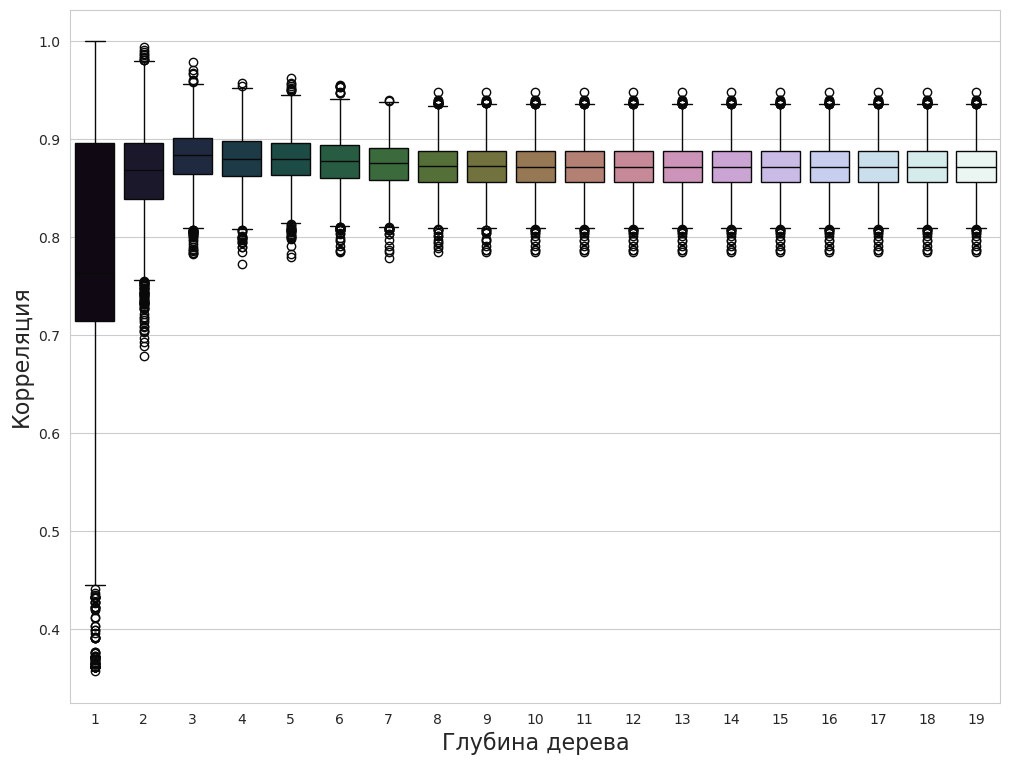

In [22]:
sns.boxplot(x=np.repeat(n_depth, len(correlations_d[0])), y=np.concatenate(correlations_d), palette="cubehelix")
plt.xlabel("Глубина дерева", fontsize=16)
plt.ylabel("Корреляция", fontsize=16)
plt.show()

Опишите ваши наблюдения:

* Корреляция базовых моделей наблюдается при всех вариантах max_features. С увеличением параметра корреляция растёт и сохраняет постоянство;
* Параметр max_depth сильно не влияет на корреляцию деревьев при значениях > 2

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [23]:
#!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("../data/heart.csv")

In [24]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
178   43    1   0       120   177    0        0      120      1      2.5   
298   57    0   0       140   241    0        1      123      1      0.2   
201   60    1   0       125   258    0        0      141      1      2.8   
246   56    0   0       134   409    0        0      150      1      1.9   
153   66    0   2       146   278    0        0      152      0      0.0   

     slope  ca  thal  
178      1   0     3  
298      1   0     3  
201      1   1     3  
246      1   2     3  
153      1   1     2

Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [25]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [26]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

voting_hard = VotingClassifier(base_models, voting='hard')
voting_soft = VotingClassifier(base_models, voting='soft')

## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219


RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.8281746031746032
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.8134522115571786
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training from score 0.092782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [27]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [28]:
voting_hard.fit(X_train, y_train)
voting_soft.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

VotingClassifier(estimators=[('DT',
                              DecisionTreeClassifier(max_depth=10,
                                                     min_samples_leaf=10,
                                                     random_state=111)),
                             ('RF',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=111)),
                             ('ETC', ExtraTreesClassifier(random_state=111)),
                             ('KNN', KNeighborsClassifier(weights='distance')),
                             ('SVC_LIN',
                              SVC(kernel='linear', probability=True,
                                  random_state=111)),
                             ('SVC_RBF',
                              SV...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='binary:logistic',
                                              random_state=111, reg_alpha=None, ...)),
                             ('LR',
                              LogisticRegression(max_iter=10000,
                                                 solver='liblinear')),
                             ('NB', GaussianNB())],
                 voting='soft')

In [29]:
correlations = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging

In [30]:
rows = set([est[0].__class__.__name__ for est in correlations])
cols = set([est[1].__class__.__name__ for est in correlations])

common = list(rows.union(cols))

models_data = pd.DataFrame(index=common, columns=common)

for est1, est2, corr in correlations:
    model_name1 = est1.__class__.__name__
    model_name2 = est2.__class__.__name__
    models_data.loc[model_name1, model_name2] = corr
    models_data.loc[model_name2, model_name1] = corr

# Заполняем диагональные значения
for model in common:
    # Устанавливаем значение 1 на диагонали
    models_data.loc[model, model] = 1

# Преобразуем все значения в тип float
models_data = models_data.astype(float)

In [31]:
models_data

CatBoostClassifier  GaussianNB  XGBClassifier  \
CatBoostClassifier                1.000000    0.824656       0.933990   
GaussianNB                        0.824656    1.000000       0.713940   
XGBClassifier                     0.933990    0.713940       1.000000   
LGBMClassifier                    0.882031    0.742768       0.843174   
DecisionTreeClassifier            0.787569    0.682771       0.808830   
LogisticRegression                0.870647    0.892515       0.800997   
SVC                               0.310658    0.422335       0.226339   
KNeighborsClassifier              0.317207    0.231372       0.303368   
XGBRFClassifier                   0.945480    0.737795       0.934112   
RandomForestClassifier            0.945070    0.798843       0.896641   
ExtraTreesClassifier              0.952720    0.852299       0.872143   

                        LGBMClassifier  DecisionTreeClassifier  \
CatBoostClassifier            0.882031                0.787569   
GaussianNB                    0.742768                0.682771   
XGBClassifier                 0.843174                0.808830   
LGBMClassifier                1.000000                0.861266   
DecisionTreeClassifier        0.861266                1.000000   
LogisticRegression            0.789240                0.739982   
SVC                           0.389275                0.282014   
KNeighborsClassifier          0.401503                0.313329   
XGBRFClassifier               0.931815                0.891293   
RandomForestClassifier        0.914669                0.813489   
ExtraTreesClassifier          0.859303                0.774954   

                        LogisticRegression       SVC  KNeighborsClassifier  \
CatBoostClassifier                0.870647  0.310658              0.317207   
GaussianNB                        0.892515  0.422335              0.231372   
XGBClassifier                     0.800997  0.226339              0.303368   
LGBMClassifier                    0.789240  0.389275              0.401503   
DecisionTreeClassifier            0.739982  0.282014              0.313329   
LogisticRegression                1.000000  0.401675              0.269734   
SVC                               0.401675  1.000000              0.565980   
KNeighborsClassifier              0.269734  0.565980              1.000000   
XGBRFClassifier                   0.807619  0.322668              0.388538   
RandomForestClassifier            0.837771  0.405527              0.392417   
ExtraTreesClassifier              0.869349  0.358855              0.322398   

                        XGBRFClassifier  RandomForestClassifier  \
CatBoostClassifier             0.945480                0.945070   
GaussianNB                     0.737795                0.798843   
XGBClassifier                  0.934112                0.896641   
LGBMClassifier                 0.931815                0.914669   
DecisionTreeClassifier         0.891293                0.813489   
LogisticRegression             0.807619                0.837771   
SVC                            0.322668                0.405527   
KNeighborsClassifier           0.388538                0.392417   
XGBRFClassifier                1.000000                0.936603   
RandomForestClassifier         0.936603                1.000000   
ExtraTreesClassifier           0.897705                0.921565   

                        ExtraTreesClassifier  
CatBoostClassifier                  0.952720  
GaussianNB                          0.852299  
XGBClassifier                       0.872143  
LGBMClassifier                      0.859303  
DecisionTreeClassifier              0.774954  
LogisticRegression                  0.869349  
SVC                                 0.358855  
KNeighborsClassifier                0.322398  
XGBRFClassifier                     0.897705  
RandomForestClassifier              0.921565  
ExtraTreesClassifier                1.000000

In [32]:
#Первый вопрос - и что теперь с этим делать
#Будем перебирать...
new_models = [
     ("DT", dt), 
     ("RF", rf), 
     ("ETC", etc), 
     ("KNN", knn), 
     ("SVC_LIN", svc_lin), 
     ("SVC_RBF", svc_rbf), 
     ("CAT", cat), 
     ("LGBM", lgbm), 
     ("LGBM_RF", lgbm_rf), 
     ("XGB", xgb), 
     ("XGB_RF", xgb_rf), 
     ("LR", lr), 
     ("NB", nb)
]

In [33]:
from sklearn.metrics import f1_score

new_models_voting_soft = VotingClassifier(new_models, voting='soft')
new_models_voting_soft.fit(X_train, y_train)
preds = new_models_voting_soft.predict(X_test)

print(f"{new_models_voting_soft.__class__.__name__}: {f1_score(y_test, preds)}")

[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [34]:
new_models = [
     #("DT", dt), 
     #("RF", rf), 
     ("ETC", etc), 
     #("KNN", knn), 
     #("SVC_LIN", svc_lin), 
     #("SVC_RBF", svc_rbf), 
     #("CAT", cat), 
     #("LGBM", lgbm), 
     #("LGBM_RF", lgbm_rf), 
     #("XGB", xgb), 
     #("XGB_RF", xgb_rf), 
     #("LR", lr), 
     ("NB", nb)
]

In [35]:
new_models_voting_soft = VotingClassifier(new_models, voting='soft')
new_models_voting_soft.fit(X_train, y_train)
preds = new_models_voting_soft.predict(X_test)

print(f"{new_models_voting_soft.__class__.__name__}: {f1_score(y_test, preds)}")
#Я перебирала попарно каждую с каждой и получила высокий скор на 3 круге

VotingClassifier: 0.9072164948453608


### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [4]:
data = pd.read_csv("../data/churn.csv")
data.head()

State  Account Length  Area Code     Phone Int'l Plan VMail Plan  \
0    KS             128        415  382-4657         no        yes   
1    OH             107        415  371-7191         no        yes   
2    NJ             137        415  358-1921         no         no   
3    OH              84        408  375-9999        yes         no   
4    OK              75        415  330-6626        yes         no   

   VMail Message  Day Mins  Day Calls  Day Charge  ...  Eve Calls  Eve Charge  \
0             25     265.1        110       45.07  ...         99       16.78   
1             26     161.6        123       27.47  ...        103       16.62   
2              0     243.4        114       41.38  ...        110       10.30   
3              0     299.4         71       50.90  ...         88        5.26   
4              0     166.7        113       28.34  ...        122       12.61   

   Night Mins  Night Calls  Night Charge  Intl Mins  Intl Calls  Intl Charge  \
0       244.7           91         11.01       10.0           3         2.70   
1       254.4          103         11.45       13.7           3         3.70   
2       162.6          104          7.32       12.2           5         3.29   
3       196.9           89          8.86        6.6           7         1.78   
4       186.9          121          8.41       10.1           3         2.73   

   CustServ Calls  Churn?  
0               1  False.  
1               1  False.  
2               0  False.  
3               2  False.  
4               3  False.  

[5 rows x 21 columns]

In [5]:
data.info() #3333 наблюдения

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [6]:
data.describe()

Account Length    Area Code  VMail Message     Day Mins    Day Calls  \
count     3333.000000  3333.000000    3333.000000  3333.000000  3333.000000   
mean       101.064806   437.182418       8.099010   179.775098   100.435644   
std         39.822106    42.371290      13.688365    54.467389    20.069084   
min          1.000000   408.000000       0.000000     0.000000     0.000000   
25%         74.000000   408.000000       0.000000   143.700000    87.000000   
50%        101.000000   415.000000       0.000000   179.400000   101.000000   
75%        127.000000   510.000000      20.000000   216.400000   114.000000   
max        243.000000   510.000000      51.000000   350.800000   165.000000   

        Day Charge     Eve Mins    Eve Calls   Eve Charge   Night Mins  \
count  3333.000000  3333.000000  3333.000000  3333.000000  3333.000000   
mean     30.562307   200.980348   100.114311    17.083540   200.872037   
std       9.259435    50.713844    19.922625     4.310668    50.573847   
min       0.000000     0.000000     0.000000     0.000000    23.200000   
25%      24.430000   166.600000    87.000000    14.160000   167.000000   
50%      30.500000   201.400000   100.000000    17.120000   201.200000   
75%      36.790000   235.300000   114.000000    20.000000   235.300000   
max      59.640000   363.700000   170.000000    30.910000   395.000000   

       Night Calls  Night Charge    Intl Mins   Intl Calls  Intl Charge  \
count  3333.000000   3333.000000  3333.000000  3333.000000  3333.000000   
mean    100.107711      9.039325    10.237294     4.479448     2.764581   
std      19.568609      2.275873     2.791840     2.461214     0.753773   
min      33.000000      1.040000     0.000000     0.000000     0.000000   
25%      87.000000      7.520000     8.500000     3.000000     2.300000   
50%     100.000000      9.050000    10.300000     4.000000     2.780000   
75%     113.000000     10.590000    12.100000     6.000000     3.270000   
max     175.000000     17.770000    20.000000    20.000000     5.400000   

       CustServ Calls  
count     3333.000000  
mean         1.562856  
std          1.315491  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          2.000000  
max          9.000000

Нашла описание df
1- State: the US state in which the customer resides, indicated by a two-letter abbreviation

2- Account Length: the number of days that this account has been active

3- Area Code: the three-digit area code of the corresponding customer’s phone number

4- Phone: the remaining seven-digit phone number

5- Int’l Plan: whether the customer has an international calling plan: yes/no

6- VMail Plan: whether the customer has a voice mail feature: yes/no

7- VMail Message: presumably the average number of voice mail messages per month

8- Day Mins: the total number of calling minutes used during the day

9- Day Calls: the total number of calls placed during the day

10- Day Charge: the billed cost of daytime calls

11- Eve Mins: the total number of calling minutes used during the evening

12- Eve Calls: the total number of calls placed during the evening

13- Eve Charge: the billed cost of evening time calls

14- Night Mins: the total number of calling minutes used during the night

15- Night Calls: the total number of calls placed during the night

16- Night Charge: the billed cost of nighttime calls

17- Intl Mins: the total number of international minutes

18- Intl Calls: the total number of international calls

19- Intl Charge: the billed cost for international calls

20- CustServ Calls: the number of calls placed to Customer Service

21- Churn?: whether the customer left the service: true/false

Видим, что можем дропнуть сам номер телефона, штат в принципе тоже

In [7]:
num_cols = ['Account Length',  
            'VMail Message', 
            'Day Mins', 
            'Day Calls', 
            'Day Charge',
            'Eve Mins', 
            'Eve Calls', 
            'Eve Charge', 
            'Night Mins', 
            'Night Calls',
            'Night Charge', 
            'Intl Mins', 
            'Intl Calls', 
            'Intl Charge',
            'CustServ Calls']

cat_cols = [ 'Int\'l Plan', 
            'VMail Plan']

target_col = 'Churn?'

In [8]:
data[target_col] = data[target_col].replace(['True.', 'False.'], [1, 0])
data[target_col]
data[target_col].value_counts()

Churn?
0    2850
1     483
Name: count, dtype: int64

In [9]:
data['Int\'l Plan'] = data['Int\'l Plan'].replace(['yes', 'no'], [1, 0])
data['VMail Plan'] = data['VMail Plan'].replace(['yes', 'no'], [1, 0])

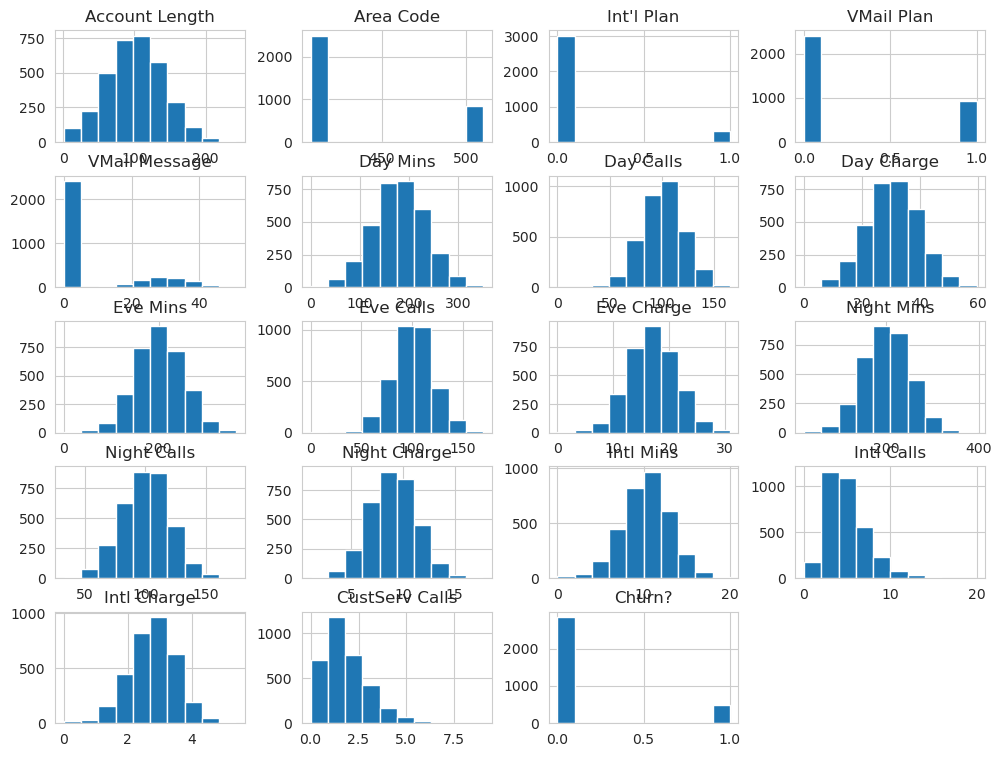

In [10]:
data.hist()
plt.show()


In [11]:
X = data[cat_cols + num_cols]
y = data[target_col]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## CatBoost

   * iterations:
        Количество итераций обучения модели (по умолчанию 1000).

   * learning_rate:
        Скорость обучения, определяющая величину изменения весов на каждой итерации (по умолчанию 0.03).

   * depth:
        Глубина деревьев решений (по умолчанию 6).

   * l2_leaf_reg:
        Коэффициент регуляризации L2 (по умолчанию 3).

   * model_size_reg:
        Коэффициент регуляризации размера модели (по умолчанию 1).

   * bagging_temperature:
        Температура бэггинга, которая влияет на частоту случайной выборки объектов в бэггинге (по умолчанию 1).

   * random_strength:
        Сила случайного сдвига, используемого для изменения обучения (по умолчанию 1).

   * border_count:
        Количество точек нарезки для числовых признаков (по умолчанию 254).

   * scale_pos_weight:
        Вес положительных примеров для балансировки набора данных (по умолчанию 1).

   * subsample:
        Доля данных, используемых для обучения каждого дерева (по умолчанию 0.8).

   * max_leaves:
        Максимальное количество листьев в дереве (по умолчанию 31).

   * permutation_count:
        Количество перестановок, используемых для построения деревьев (по умолчанию 1).

In [13]:
cat_boost = catboost.CatBoostClassifier(random_seed=SEED)

In [14]:
params = {
    'iterations': [500, 1000], 
    'learning_rate': [0.03, 0.1],
    'depth': [6, 8],
    'l2_leaf_reg': [3, 5, 6]
}

In [15]:
grid_search = GridSearchCV(estimator=cat_boost, param_grid=params, cv=5, scoring='f1')

In [16]:
grid_search.fit(X_train, y_train)

0:	learn: 0.6557794	total: 69ms	remaining: 34.4s
1:	learn: 0.6304633	total: 80.7ms	remaining: 20.1s
2:	learn: 0.6032273	total: 86.9ms	remaining: 14.4s
3:	learn: 0.5798158	total: 91.9ms	remaining: 11.4s
4:	learn: 0.5607360	total: 96.3ms	remaining: 9.54s
5:	learn: 0.5392162	total: 101ms	remaining: 8.31s
6:	learn: 0.5190645	total: 106ms	remaining: 7.49s
7:	learn: 0.4971300	total: 112ms	remaining: 6.89s
8:	learn: 0.4819703	total: 130ms	remaining: 7.09s
9:	learn: 0.4634011	total: 136ms	remaining: 6.68s
10:	learn: 0.4502126	total: 142ms	remaining: 6.31s
11:	learn: 0.4332242	total: 148ms	remaining: 6.02s
12:	learn: 0.4199805	total: 154ms	remaining: 5.76s
13:	learn: 0.4041123	total: 158ms	remaining: 5.5s
14:	learn: 0.3953780	total: 163ms	remaining: 5.26s
15:	learn: 0.3817782	total: 167ms	remaining: 5.06s
16:	learn: 0.3708522	total: 172ms	remaining: 4.88s
17:	learn: 0.3638678	total: 177ms	remaining: 4.74s
18:	learn: 0.3537232	total: 181ms	remaining: 4.59s
19:	learn: 0.3448165	total: 186ms	remai

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x76a300f18e30>,
             param_grid={'depth': [6, 8], 'iterations': [500, 1000],
                         'l2_leaf_reg': [3, 5, 6],
                         'learning_rate': [0.03, 0.1]},
             scoring='f1')

In [18]:
print(grid_search.best_params_)

{'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 5, 'learning_rate': 0.03}


In [21]:
best_cat_boost = grid_search.best_params_
best_cat_boost = catboost.CatBoostClassifier(iterations=1000, learning_rate=0.03, l2_leaf_reg=5, depth=6,random_seed=SEED)
best_cat_boost.fit(X_train, y_train)
preds = best_cat_boost.predict(X_test)

0:	learn: 0.6576130	total: 2.75ms	remaining: 2.75s
1:	learn: 0.6326570	total: 5.02ms	remaining: 2.5s
2:	learn: 0.6047907	total: 6.97ms	remaining: 2.32s
3:	learn: 0.5820067	total: 9.01ms	remaining: 2.24s
4:	learn: 0.5633673	total: 10.8ms	remaining: 2.16s
5:	learn: 0.5418441	total: 12.5ms	remaining: 2.07s
6:	learn: 0.5221694	total: 14.2ms	remaining: 2.02s
7:	learn: 0.4999034	total: 16.3ms	remaining: 2.02s
8:	learn: 0.4777114	total: 18.1ms	remaining: 1.99s
9:	learn: 0.4602454	total: 21.2ms	remaining: 2.1s
10:	learn: 0.4478288	total: 23ms	remaining: 2.07s
11:	learn: 0.4307220	total: 24.9ms	remaining: 2.05s
12:	learn: 0.4183163	total: 26.9ms	remaining: 2.04s
13:	learn: 0.4032012	total: 28.7ms	remaining: 2.02s
14:	learn: 0.3945145	total: 30.5ms	remaining: 2s
15:	learn: 0.3805212	total: 32.6ms	remaining: 2s
16:	learn: 0.3706108	total: 34.4ms	remaining: 1.99s
17:	learn: 0.3618190	total: 36.5ms	remaining: 1.99s
18:	learn: 0.3518307	total: 38.3ms	remaining: 1.98s
19:	learn: 0.3438699	total: 40.6

In [23]:
print(confusion_matrix(y_test, preds))  

# Отчёт о классификации
print('\nОтчёт:')
print(classification_report(y_test, preds))

print(f'accuracy = {accuracy_score(y_test, preds):.3f}')

[[847  12]
 [ 40 101]]

Отчёт:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       859
           1       0.89      0.72      0.80       141

    accuracy                           0.95      1000
   macro avg       0.92      0.85      0.88      1000
weighted avg       0.95      0.95      0.95      1000

accuracy = 0.948


    Precision:
        Precision для класса 0 (например, отсутствие события) составляет 0.95, что означает, что 95% объектов, которые модель предсказала как класс 0, действительно принадлежат к классу 0.
        Precision для класса 1 (например, наличие события) составляет 0.89, что означает, что 89% объектов, которые модель предсказала как класс 1, действительно принадлежат к классу 1.

    Recall:
        Recall для класса 0 составляет 0.99, что означает, что модель смогла обнаружить 99% всех объектов класса 0.
        Recall для класса 1 составляет 0.72, что означает, что модель смогла обнаружить только 72% всех объектов класса 1.

## XGBRFClassifier

In [33]:
XGBRF_model = xgboost.XGBRFClassifier(random_state=SEED)

In [37]:
grid_param_xgbrf = {'objective':['binary:logistic'],
                    'learning_rate': [0.1, 0.05, 0.03],
                    'max_depth': [3, 6, 8],
                    'num_parallel_tree': [50, 100, 150, 500],
                    'subsample': [0.8, 1],
                    'colsample_bynode': [0.5, 0.8],
                    'seed': [SEED],
                    'eval_metric': ['logloss']
                   }

In [38]:
grid_search_xgbrf = GridSearchCV(estimator=XGBRF_model,
                                 error_score = 'raise',
                                 param_grid=grid_param_xgbrf,
                                 scoring='f1',
                                 cv=5,
#                                  n_jobs=-1,
                                 verbose=0)

grid_search_xgbrf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=XGBRFClassifier(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bytree=None, device=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=None, grow_policy=None,
                                       importance_type=None,
                                       interaction_constraints=None,
                                       max_bin=None, max_ca...
                                       multi_strategy=None, n_estimators=None,
                                       n_jobs=None, num_parallel_tree=None,
                                       objective='binary:logistic',
                                       random_state=111, reg_alpha=None, ...),
             param_grid={'colsample_bynode': [0.5, 0.8],
                         'eval_metric': ['logloss'],
                         'learning_rate': [0.1, 0.05, 0.03],
                         'max_depth': [3, 6, 8],
                         'num_parallel_tree': [50, 100, 150, 500],
                         'objective': ['binary:logistic'], 'seed': [111],
                         'subsample': [0.8, 1]},
             scoring='f1')

In [39]:
print(grid_search_xgbrf.best_params_)
print(grid_search_xgbrf.best_score_)

{'colsample_bynode': 0.5, 'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 3, 'num_parallel_tree': 50, 'objective': 'binary:logistic', 'seed': 111, 'subsample': 0.8}
0.0


In [40]:
best_XGBRF = grid_search_xgbrf.best_estimator_

best_XGBRF.fit(X_train, y_train)
preds = best_XGBRF.predict(X_test)

In [41]:
print(confusion_matrix(y_test, preds))  

# Отчёт о классификации
print('\nОтчёт:')
print(classification_report(y_test, preds))

print(f'accuracy = {accuracy_score(y_test, preds):.3f}')

[[859   0]
 [141   0]]

Отчёт:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       859
           1       0.00      0.00      0.00       141

    accuracy                           0.86      1000
   macro avg       0.43      0.50      0.46      1000
weighted avg       0.74      0.86      0.79      1000

accuracy = 0.859


### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

In [ ]:
  ________                  .___      __      ___.    
 /  _____/  ____   ____   __| _/     |__| ____\_ |__  
/   \  ___ /  _ \ /  _ \ / __ |      |  |/  _ \| __ \ 
\    \_\  (  <_> |  <_> ) /_/ |      |  (  <_> ) \_\ \
 \______  /\____/ \____/\____ |  /\__|  |\____/|___  /
        \/                   \/  \______|          \/

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

In [ ]:
Мой кампухтер очень устал, это все было интересно и мне кажется, я все поняла. В этот раз случилось озарение)